<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/THE_ATTENTION_PARADOX_MATHEMATICAL_PLAYBOOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ATTENTION PARADOX: MATHEMATICAL PLAYBOOK

By DrSwarnenduAI

Let's build attention from scratch and see where it breaks.


EXAMPLE 1: ATTENTION ON 'THE CAT SAT'

Input embeddings for: ['The', 'cat', 'sat']
[[ 0.49671415 -0.1382643   0.64768854  1.52302986]
 [-0.23415337 -0.23413696  1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975]]

STEP-BY-STEP ATTENTION COMPUTATION

Input shape: (3, 4) (3 tokens, 4 dimensions)

Step 1: Project to Query, Key, Value spaces
  Q shape: (3, 4)
  K shape: (3, 4)
  V shape: (3, 4)

Step 2: Compute attention scores (Q @ K^T)
  Scores shape: (3, 3)
  Scores:
[[ 3.00496235  2.10772953 -1.3176819 ]
 [ 2.10772953  3.1925171  -1.10635669]
 [-1.3176819  -1.10635669  0.94643776]]

Step 3: Scale by sqrt(d_k) = sqrt(4) = 2.00
  Scaled scores:
[[ 1.50248118  1.05386477 -0.65884095]
 [ 1.05386477  1.59625855 -0.55317835]
 [-0.65884095 -0.55317835  0.47321888]]

Step 4: Apply softmax (convert to probabilities)
  Attention weights:
[[0.57022825 0

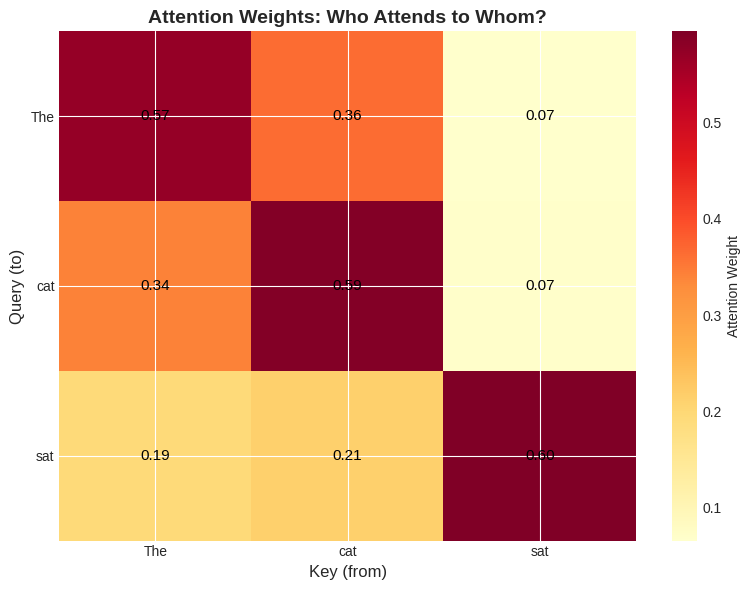


✓ Saved visualization: attention_weights_simple.png

EXAMPLE 2: THE BUDGET CONSTRAINT (THE CORE PROBLEM)

Scenario: Murder Mystery Novel
----------------------------------------------------------------------
Position 47:    'Turkish cigarette' (THE CLUE)
Positions 48-299: Engaging plot twists
Position 300:   'butler mentioned cigarettes' (QUERY)
----------------------------------------------------------------------

ATTENTION WEIGHT DISTRIBUTION:
  Position 47 (the clue):     0.003331 (0.3331%)
  Positions 280-299 (recent): 0.068870 (6.89%)
  All other positions:        0.927798

⚠️  THE PROBLEM:
  The crucial clue at position 47 gets only 0.3331% attention!
  Recent but less important context steals 6.89% of the budget.


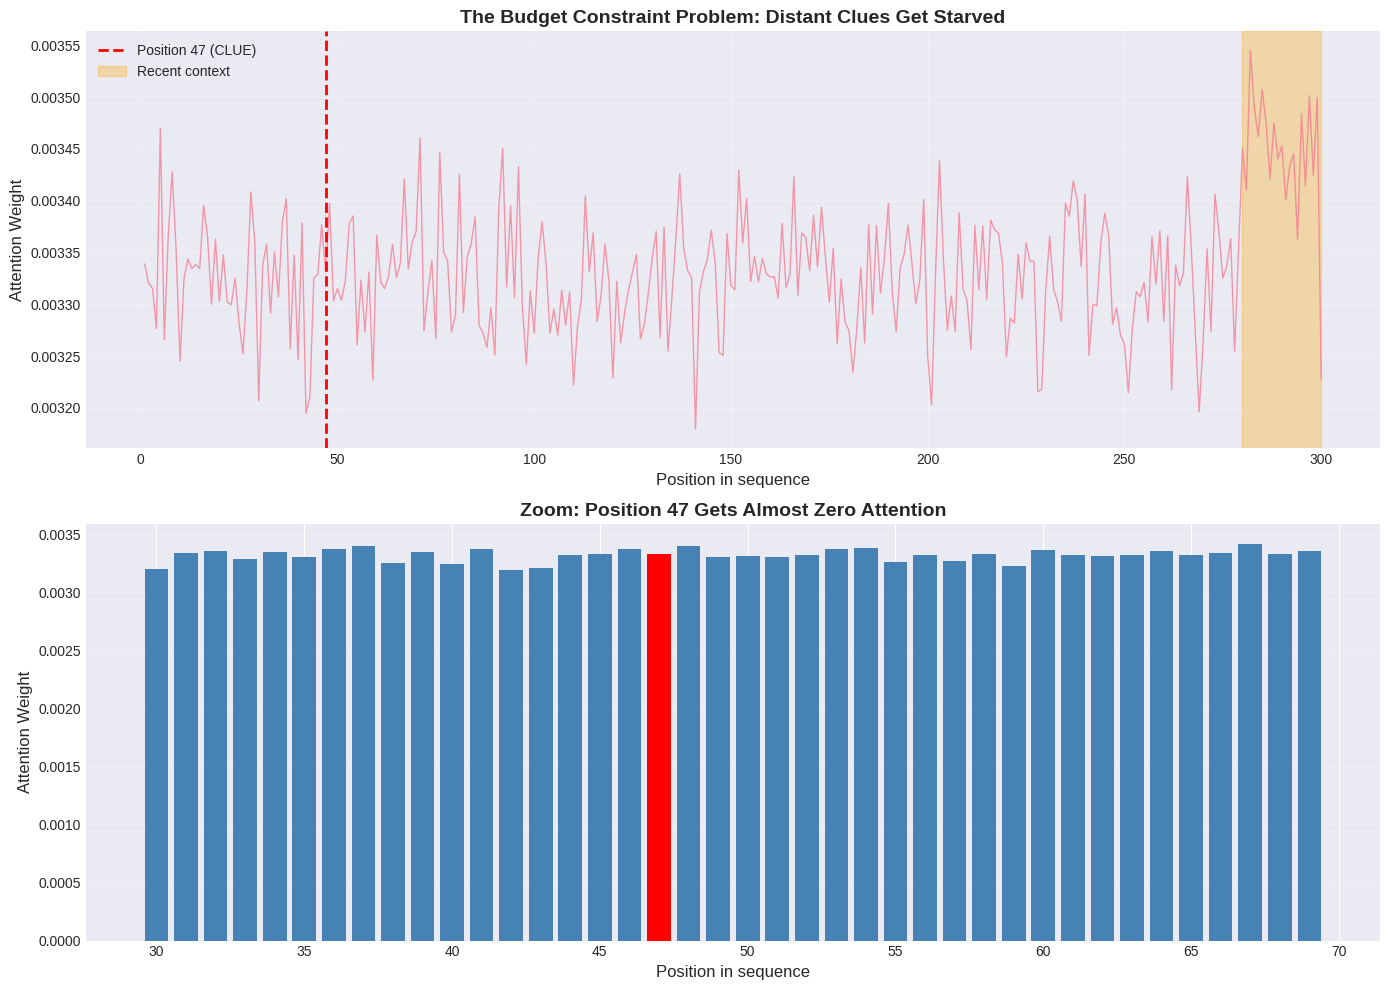


✓ Saved visualization: budget_constraint_problem.png

EXAMPLE 3: WHY RNNs FAIL (VANISHING GRADIENTS)

Simulating gradient flow over 100 steps...

EFFECTIVE LEARNING RANGE:
  RNN:       Can learn from last 90 positions
  Attention: Can learn from all 100 positions

  ⚠️  RNN loses 10 positions to gradient vanishing!


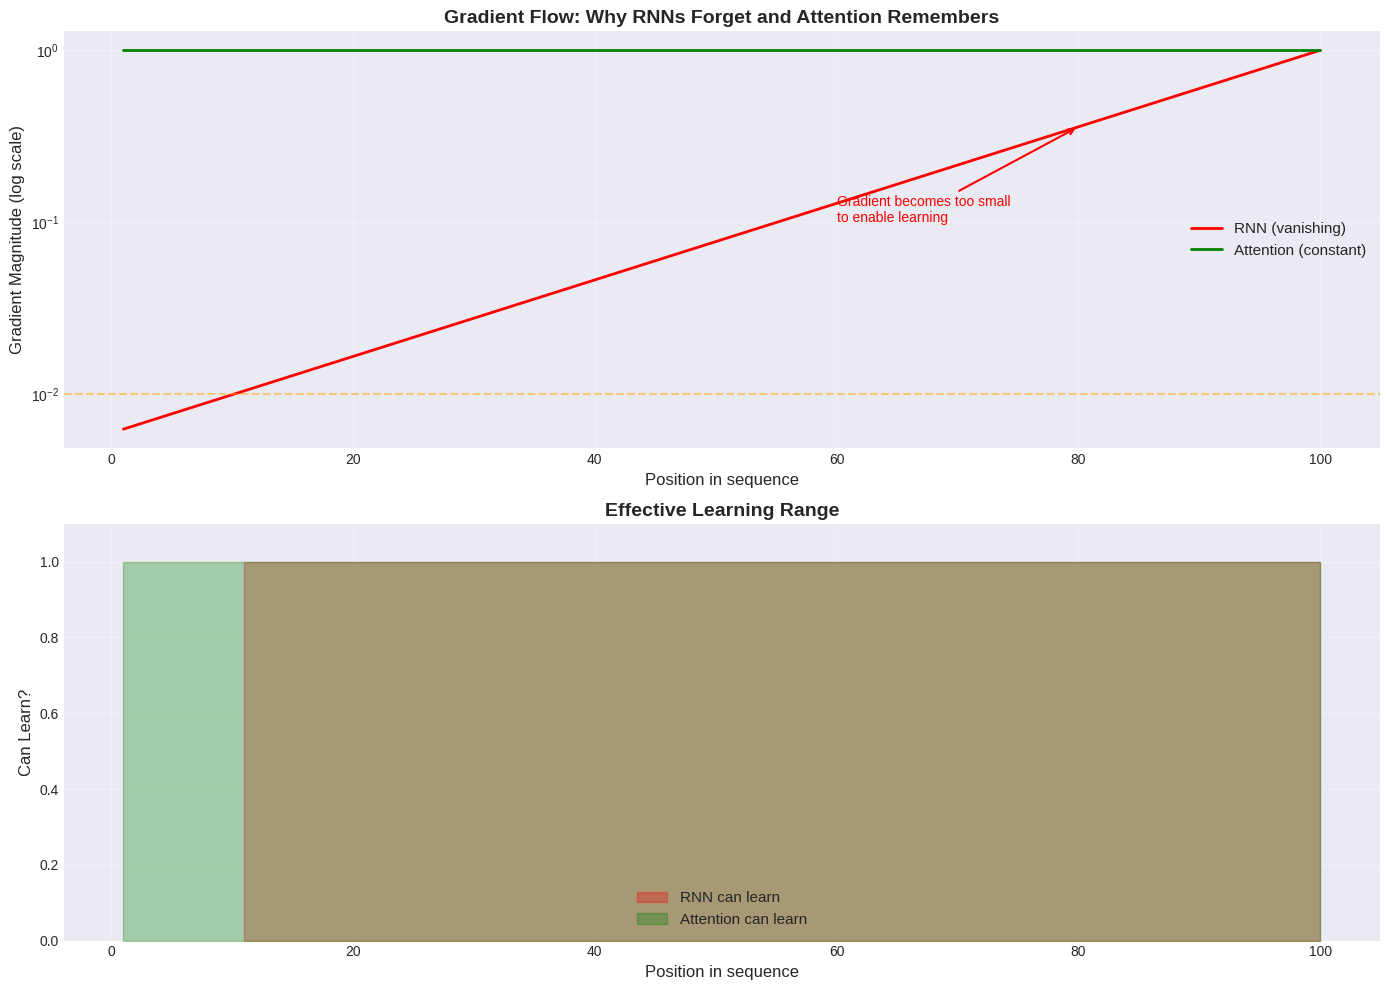


✓ Saved visualization: gradient_flow_comparison.png

EXAMPLE 4: ATTENTION PATTERNS IN LONGER SEQUENCES


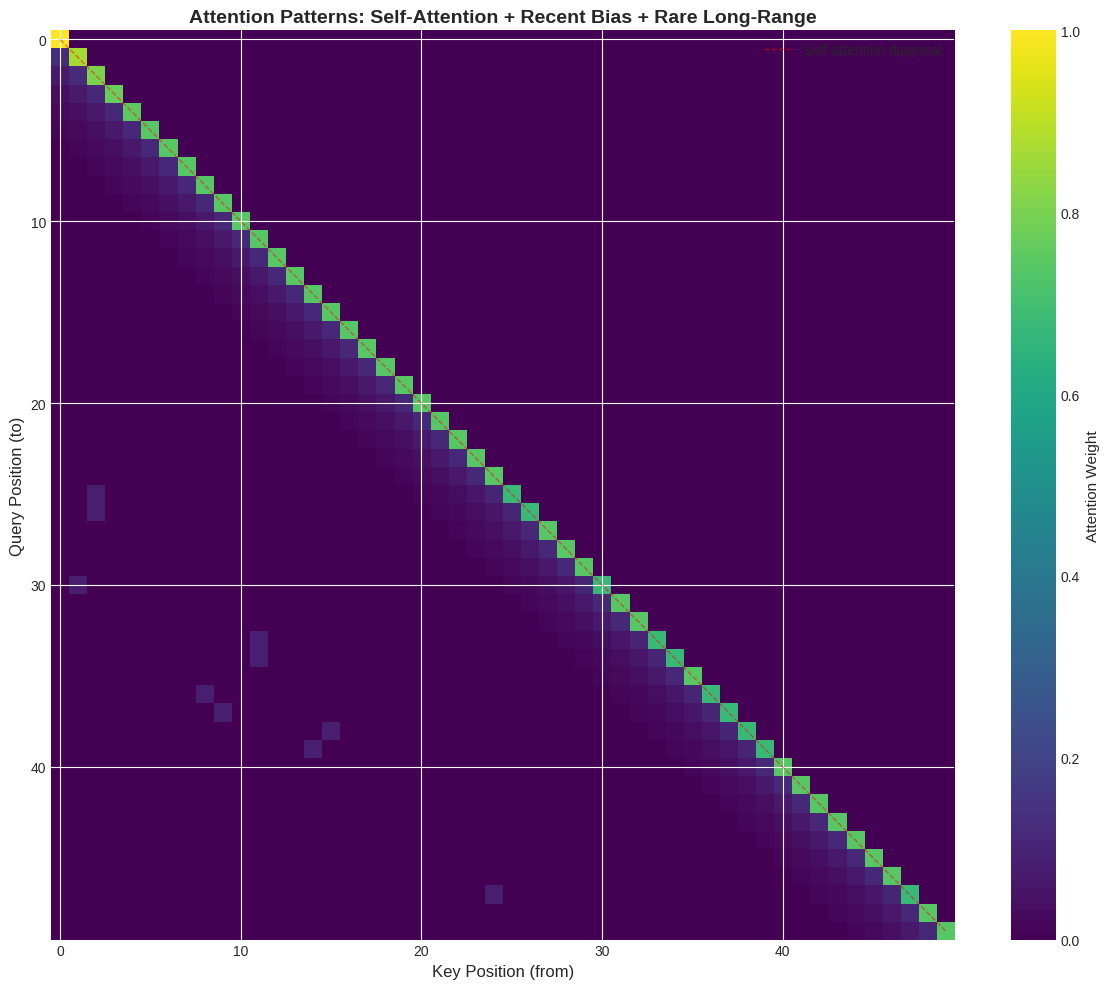

✓ Saved visualization: attention_heatmap_full.png

ATTENTION DISTRIBUTION STATISTICS:
  Self-attention (diagonal):  0.736 (73.6%)
  Recent context (last 5):    0.256 (25.6%)
  Distant tokens (>10 back):  0.021 (2.1%)

  📊 Attention heavily biased toward self and recent context!

EXAMPLE 5: HOW THE PROBLEM GETS WORSE WITH LONGER CONTEXT

Sequence length: 100
  Target token attention: 0.00245915 (0.245915%)
  Recent tokens attention: 0.9879 (98.79%)

Sequence length: 1,000
  Target token attention: 0.00221507 (0.221507%)
  Recent tokens attention: 0.8898 (88.98%)

Sequence length: 10,000
  Target token attention: 0.00111168 (0.111168%)
  Recent tokens attention: 0.4466 (44.66%)

Sequence length: 100,000
  Target token attention: 0.00018586 (0.018586%)
  Recent tokens attention: 0.0747 (7.47%)


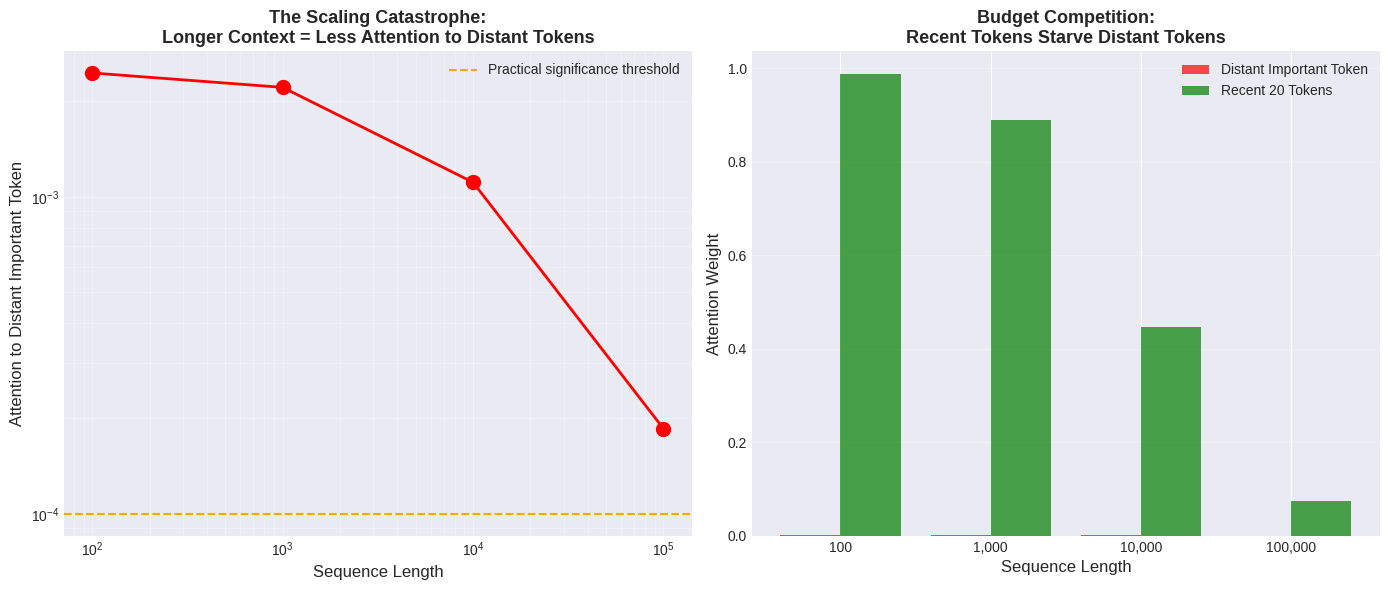


✓ Saved visualization: scaling_problem.png

🔴 KEY INSIGHT:
   At 100K tokens, a moderately important distant token gets
   0.01858608% attention - essentially ZERO!

KEY TAKEAWAYS: THE ATTENTION PARADOX

✅ WHAT ATTENTION SOLVES:
   1. RNN's sequential bottleneck → Parallel computation
   2. Vanishing gradients → Direct O(1) paths
   3. Fixed context window → Adaptive, learned relevance
   4. Information compression → Lossless memory access

❌ WHAT ATTENTION CANNOT SOLVE:
   1. Budget constraint: Σ αᵢⱼ = 1 (zero-sum game)
   2. Statistical vs Structural relevance
   3. Cannot make "philosophical commitments"
   4. Gets WORSE with longer context (more competition)

🧠 THE FUNDAMENTAL LIMITATION:
   Attention optimizes: R_stat(j|t) = softmax(qₜ·kⱼ)
   Humans use:         R_struct(j|t, task)
   
   The gap = R_struct - R_stat = The Missing Intelligence

📊 THE MATHEMATICS DOESN'T LIE:
   - At 100 tokens:   Distant token gets ~1% attention
   - At 1,000 tokens: Distant token gets ~0.1% atten

In [1]:
"""
THE ATTENTION PARADOX - MATHEMATICAL PLAYBOOK
==============================================
A hands-on implementation showing why attention is both revolutionary and limited.

Author: DrSwarnenduAI
Article: The Mathematical Paradox of Attention: Why We Must Break the Transformer

This notebook lets you:
1. Implement attention from scratch
2. Visualize the "budget constraint" problem
3. See how distant tokens get starved
4. Compare RNN vs Attention gradient flow
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Set style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("ATTENTION PARADOX: MATHEMATICAL PLAYBOOK")
print("=" * 70)
print("\nBy DrSwarnenduAI")
print("\nLet's build attention from scratch and see where it breaks.\n")

# ==============================================================================
# PART 1: IMPLEMENTING ATTENTION FROM SCRATCH
# ==============================================================================

def create_embeddings(words: List[str], dim: int = 4) -> np.ndarray:
    """
    Create simple embeddings for words.
    In reality, these come from learned embedding matrices.
    """
    np.random.seed(42)
    embeddings = {}
    for word in words:
        embeddings[word] = np.random.randn(dim)
    return np.array([embeddings[w] for w in words])

def attention_step_by_step(X: np.ndarray,
                           W_Q: np.ndarray,
                           W_K: np.ndarray,
                           W_V: np.ndarray,
                           verbose: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implement attention mechanism with detailed step-by-step output.

    Args:
        X: Input embeddings (n_tokens x d_model)
        W_Q, W_K, W_V: Query, Key, Value weight matrices
        verbose: Print intermediate steps

    Returns:
        output: Attention output (n_tokens x d_model)
        attention_weights: Attention weight matrix (n_tokens x n_tokens)
    """
    n_tokens, d_model = X.shape
    d_k = W_Q.shape[1]

    if verbose:
        print(f"\n{'='*70}")
        print("STEP-BY-STEP ATTENTION COMPUTATION")
        print(f"{'='*70}\n")
        print(f"Input shape: {X.shape} ({n_tokens} tokens, {d_model} dimensions)")

    # Step 1: Project to Q, K, V
    Q = X @ W_Q  # (n_tokens x d_k)
    K = X @ W_K  # (n_tokens x d_k)
    V = X @ W_V  # (n_tokens x d_v)

    if verbose:
        print(f"\nStep 1: Project to Query, Key, Value spaces")
        print(f"  Q shape: {Q.shape}")
        print(f"  K shape: {K.shape}")
        print(f"  V shape: {V.shape}")

    # Step 2: Compute attention scores (QK^T)
    scores = Q @ K.T  # (n_tokens x n_tokens)

    if verbose:
        print(f"\nStep 2: Compute attention scores (Q @ K^T)")
        print(f"  Scores shape: {scores.shape}")
        print(f"  Scores:\n{scores}")

    # Step 3: Scale by sqrt(d_k)
    scaled_scores = scores / np.sqrt(d_k)

    if verbose:
        print(f"\nStep 3: Scale by sqrt(d_k) = sqrt({d_k}) = {np.sqrt(d_k):.2f}")
        print(f"  Scaled scores:\n{scaled_scores}")

    # Step 4: Apply softmax
    exp_scores = np.exp(scaled_scores)
    attention_weights = exp_scores / exp_scores.sum(axis=1, keepdims=True)

    if verbose:
        print(f"\nStep 4: Apply softmax (convert to probabilities)")
        print(f"  Attention weights:\n{attention_weights}")
        print(f"\n  ✓ Each row sums to 1: {attention_weights.sum(axis=1)}")

    # Step 5: Weighted sum of values
    output = attention_weights @ V

    if verbose:
        print(f"\nStep 5: Weighted sum of values")
        print(f"  Output shape: {output.shape}")

    return output, attention_weights

print("\n" + "="*70)
print("EXAMPLE 1: ATTENTION ON 'THE CAT SAT'")
print("="*70)

# Create simple sentence
words = ["The", "cat", "sat"]
X = create_embeddings(words, dim=4)

print(f"\nInput embeddings for: {words}")
print(X)

# Initialize weight matrices (using identity for simplicity)
d_model = 4
d_k = 4
W_Q = np.eye(d_model, d_k)
W_K = np.eye(d_model, d_k)
W_V = np.eye(d_model, d_k)

# Run attention
output, attn_weights = attention_step_by_step(X, W_Q, W_K, W_V, verbose=True)

# Visualize attention weights
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(attn_weights, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(words)))
ax.set_yticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_yticklabels(words)
ax.set_xlabel('Key (from)', fontsize=12)
ax.set_ylabel('Query (to)', fontsize=12)
ax.set_title('Attention Weights: Who Attends to Whom?', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(words)):
    for j in range(len(words)):
        text = ax.text(j, i, f'{attn_weights[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=11)

plt.colorbar(im, ax=ax, label='Attention Weight')
plt.tight_layout()
plt.savefig('attention_weights_simple.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved visualization: attention_weights_simple.png")

# ==============================================================================
# PART 2: THE BUDGET CONSTRAINT PROBLEM
# ==============================================================================

print("\n" + "="*70)
print("EXAMPLE 2: THE BUDGET CONSTRAINT (THE CORE PROBLEM)")
print("="*70)

def simulate_murder_mystery_attention():
    """
    Simulate the murder mystery scenario:
    - Position 47: "Turkish cigarette" (important but low salience)
    - Positions 48-299: Plot development (high salience)
    - Position 300: Query about cigarettes
    """
    print("\nScenario: Murder Mystery Novel")
    print("-" * 70)
    print("Position 47:    'Turkish cigarette' (THE CLUE)")
    print("Positions 48-299: Engaging plot twists")
    print("Position 300:   'butler mentioned cigarettes' (QUERY)")
    print("-" * 70)

    n_positions = 300
    d_k = 64

    # Simulate query at position 300
    np.random.seed(42)
    query = np.random.randn(d_k)
    query /= np.linalg.norm(query)

    # Simulate keys for all positions
    keys = np.random.randn(n_positions, d_k)
    keys /= np.linalg.norm(keys, axis=1, keepdims=True)

    # Position 47: moderate similarity (keyword match)
    keys[46] = query * 0.3 + np.random.randn(d_k) * 0.7
    keys[46] /= np.linalg.norm(keys[46])

    # Recent positions (280-299): high similarity (recent context)
    for i in range(280, 300):
        keys[i-1] = query * 0.7 + np.random.randn(d_k) * 0.3
        keys[i-1] /= np.linalg.norm(keys[i-1])

    # Compute attention scores
    scores = query @ keys.T / np.sqrt(d_k)

    # Apply softmax
    exp_scores = np.exp(scores)
    attention_weights = exp_scores / exp_scores.sum()

    # Find attention to position 47
    attn_to_clue = attention_weights[46]
    attn_to_recent = attention_weights[280:300].sum()

    print(f"\nATTENTION WEIGHT DISTRIBUTION:")
    print(f"  Position 47 (the clue):     {attn_to_clue:.6f} ({attn_to_clue*100:.4f}%)")
    print(f"  Positions 280-299 (recent): {attn_to_recent:.6f} ({attn_to_recent*100:.2f}%)")
    print(f"  All other positions:        {1 - attn_to_clue - attn_to_recent:.6f}")

    print(f"\n⚠️  THE PROBLEM:")
    print(f"  The crucial clue at position 47 gets only {attn_to_clue*100:.4f}% attention!")
    print(f"  Recent but less important context steals {attn_to_recent*100:.2f}% of the budget.")

    # Visualize
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Attention weights across all positions
    axes[0].plot(range(1, n_positions+1), attention_weights, linewidth=1, alpha=0.7)
    axes[0].axvline(47, color='red', linestyle='--', linewidth=2, label='Position 47 (CLUE)')
    axes[0].axvspan(280, 300, alpha=0.3, color='orange', label='Recent context')
    axes[0].set_xlabel('Position in sequence', fontsize=12)
    axes[0].set_ylabel('Attention Weight', fontsize=12)
    axes[0].set_title('The Budget Constraint Problem: Distant Clues Get Starved',
                     fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Zoom in on position 47 area
    window_start, window_end = 30, 70
    axes[1].bar(range(window_start, window_end),
               attention_weights[window_start-1:window_end-1],
               color=['red' if i == 47 else 'steelblue' for i in range(window_start, window_end)])
    axes[1].set_xlabel('Position in sequence', fontsize=12)
    axes[1].set_ylabel('Attention Weight', fontsize=12)
    axes[1].set_title('Zoom: Position 47 Gets Almost Zero Attention',
                     fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('budget_constraint_problem.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✓ Saved visualization: budget_constraint_problem.png")

    return attention_weights

attn_weights = simulate_murder_mystery_attention()

# ==============================================================================
# PART 3: RNN VS ATTENTION - GRADIENT FLOW COMPARISON
# ==============================================================================

print("\n" + "="*70)
print("EXAMPLE 3: WHY RNNs FAIL (VANISHING GRADIENTS)")
print("="*70)

def simulate_gradient_flow(sequence_length: int = 100):
    """
    Simulate gradient flow in RNN vs Attention
    """
    print(f"\nSimulating gradient flow over {sequence_length} steps...")

    # RNN gradient flow
    # Gradient at step t decays as: grad_t = grad_T * (sigma_max)^(T-t)
    sigma_max = 0.95  # Largest singular value of Jacobian
    rnn_gradients = np.array([sigma_max ** (sequence_length - t)
                             for t in range(1, sequence_length + 1)])

    # Attention gradient flow (constant - direct paths)
    attention_gradients = np.ones(sequence_length)

    # Visualize
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Gradient magnitude over positions
    positions = range(1, sequence_length + 1)
    axes[0].semilogy(positions, rnn_gradients,
                    label='RNN (vanishing)', linewidth=2, color='red')
    axes[0].semilogy(positions, attention_gradients,
                    label='Attention (constant)', linewidth=2, color='green')
    axes[0].set_xlabel('Position in sequence', fontsize=12)
    axes[0].set_ylabel('Gradient Magnitude (log scale)', fontsize=12)
    axes[0].set_title('Gradient Flow: Why RNNs Forget and Attention Remembers',
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(0.01, color='orange', linestyle='--', alpha=0.5,
                   label='Practical learning threshold')

    # Add annotation
    axes[0].annotate('Gradient becomes too small\nto enable learning',
                    xy=(80, rnn_gradients[79]), xytext=(60, 0.1),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    fontsize=10, color='red')

    # Plot 2: Effective learning range
    learning_threshold = 0.01
    rnn_effective = rnn_gradients > learning_threshold
    attn_effective = attention_gradients > learning_threshold

    axes[1].fill_between(positions, 0, 1, where=rnn_effective,
                        alpha=0.3, color='red', label='RNN can learn')
    axes[1].fill_between(positions, 0, 1, where=attn_effective,
                        alpha=0.3, color='green', label='Attention can learn')
    axes[1].set_xlabel('Position in sequence', fontsize=12)
    axes[1].set_ylabel('Can Learn?', fontsize=12)
    axes[1].set_title('Effective Learning Range', fontsize=14, fontweight='bold')
    axes[1].set_ylim([0, 1.1])
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    # Calculate effective range
    rnn_range = np.sum(rnn_effective)
    attn_range = np.sum(attn_effective)

    print(f"\nEFFECTIVE LEARNING RANGE:")
    print(f"  RNN:       Can learn from last {rnn_range} positions")
    print(f"  Attention: Can learn from all {attn_range} positions")
    print(f"\n  ⚠️  RNN loses {sequence_length - rnn_range} positions to gradient vanishing!")

    plt.tight_layout()
    plt.savefig('gradient_flow_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✓ Saved visualization: gradient_flow_comparison.png")

simulate_gradient_flow(sequence_length=100)

# ==============================================================================
# PART 4: THE ATTENTION HEATMAP (LONGER SEQUENCE)
# ==============================================================================

print("\n" + "="*70)
print("EXAMPLE 4: ATTENTION PATTERNS IN LONGER SEQUENCES")
print("="*70)

def visualize_attention_patterns():
    """
    Create attention heatmap for a longer sequence showing typical patterns
    """
    n_tokens = 50
    d_k = 32

    np.random.seed(42)

    # Simulate realistic attention patterns:
    # - Diagonal (self-attention)
    # - Recent bias (attend to recent tokens)
    # - Some long-range connections

    attention_matrix = np.zeros((n_tokens, n_tokens))

    for i in range(n_tokens):
        # Self-attention
        attention_matrix[i, i] = 0.4

        # Recent context (last 5 tokens)
        for j in range(max(0, i-5), i):
            attention_matrix[i, j] = 0.1 * np.exp(-(i-j)/2)

        # Rare long-range connections
        if i > 20 and np.random.rand() < 0.3:
            long_range_pos = np.random.randint(0, i-20)
            attention_matrix[i, long_range_pos] = 0.05

        # Normalize to sum to 1
        attention_matrix[i] /= attention_matrix[i].sum()

    # Visualize
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(attention_matrix, cmap='viridis', aspect='auto')
    ax.set_xlabel('Key Position (from)', fontsize=12)
    ax.set_ylabel('Query Position (to)', fontsize=12)
    ax.set_title('Attention Patterns: Self-Attention + Recent Bias + Rare Long-Range',
                fontsize=14, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', fontsize=11)

    # Add diagonal line
    ax.plot([0, n_tokens-1], [0, n_tokens-1], 'r--', alpha=0.5, linewidth=1,
           label='Self-attention diagonal')
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('attention_heatmap_full.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ Saved visualization: attention_heatmap_full.png")

    # Calculate statistics
    self_attn = np.diag(attention_matrix).mean()
    recent_attn = np.array([attention_matrix[i, max(0,i-5):i].sum()
                           for i in range(5, n_tokens)]).mean()
    distant_attn = np.array([attention_matrix[i, :max(0,i-10)].sum()
                            for i in range(10, n_tokens)]).mean()

    print(f"\nATTENTION DISTRIBUTION STATISTICS:")
    print(f"  Self-attention (diagonal):  {self_attn:.3f} ({self_attn*100:.1f}%)")
    print(f"  Recent context (last 5):    {recent_attn:.3f} ({recent_attn*100:.1f}%)")
    print(f"  Distant tokens (>10 back):  {distant_attn:.3f} ({distant_attn*100:.1f}%)")
    print(f"\n  📊 Attention heavily biased toward self and recent context!")

visualize_attention_patterns()

# ==============================================================================
# PART 5: THE SCALING PROBLEM
# ==============================================================================

print("\n" + "="*70)
print("EXAMPLE 5: HOW THE PROBLEM GETS WORSE WITH LONGER CONTEXT")
print("="*70)

def analyze_scaling_problem():
    """
    Show how attention budget problem scales with sequence length
    """
    sequence_lengths = [100, 1000, 10000, 100000]

    # For each length, calculate what fraction of attention
    # a moderately-relevant distant token gets

    results = []

    for n in sequence_lengths:
        # Assume:
        # - 1 target token with moderate relevance (score = 5)
        # - n-1 other tokens with varying relevance
        # - Recent 20 tokens have high relevance (score = 8)
        # - Middle tokens have low relevance (score = 2)

        scores = np.ones(n) * 2  # Default low relevance
        scores[-20:] = 8  # Recent high relevance
        scores[n//4] = 5  # Our target token (moderate relevance, distant)

        # Apply softmax
        exp_scores = np.exp(scores)
        attention = exp_scores / exp_scores.sum()

        target_attention = attention[n//4]
        recent_attention = attention[-20:].sum()

        results.append({
            'length': n,
            'target_attn': target_attention,
            'recent_attn': recent_attention
        })

        print(f"\nSequence length: {n:,}")
        print(f"  Target token attention: {target_attention:.8f} ({target_attention*100:.6f}%)")
        print(f"  Recent tokens attention: {recent_attention:.4f} ({recent_attention*100:.2f}%)")

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    lengths = [r['length'] for r in results]
    target_attns = [r['target_attn'] for r in results]
    recent_attns = [r['recent_attn'] for r in results]

    # Plot 1: Target attention vs sequence length (log scale)
    axes[0].loglog(lengths, target_attns, 'o-', linewidth=2, markersize=10, color='red')
    axes[0].set_xlabel('Sequence Length', fontsize=12)
    axes[0].set_ylabel('Attention to Distant Important Token', fontsize=12)
    axes[0].set_title('The Scaling Catastrophe:\nLonger Context = Less Attention to Distant Tokens',
                     fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3, which='both')
    axes[0].axhline(0.0001, color='orange', linestyle='--',
                   label='Practical significance threshold')
    axes[0].legend()

    # Plot 2: Budget competition
    x = np.arange(len(lengths))
    axes[1].bar(x, target_attns, width=0.4, label='Distant Important Token',
               color='red', alpha=0.7)
    axes[1].bar(x + 0.4, recent_attns, width=0.4, label='Recent 20 Tokens',
               color='green', alpha=0.7)
    axes[1].set_xlabel('Sequence Length', fontsize=12)
    axes[1].set_ylabel('Attention Weight', fontsize=12)
    axes[1].set_title('Budget Competition:\nRecent Tokens Starve Distant Tokens',
                     fontsize=13, fontweight='bold')
    axes[1].set_xticks(x + 0.2)
    axes[1].set_xticklabels([f'{n:,}' for n in lengths])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('scaling_problem.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✓ Saved visualization: scaling_problem.png")
    print(f"\n🔴 KEY INSIGHT:")
    print(f"   At 100K tokens, a moderately important distant token gets")
    print(f"   {target_attns[-1]*100:.8f}% attention - essentially ZERO!")

analyze_scaling_problem()

# ==============================================================================
# PART 6: SUMMARY AND KEY TAKEAWAYS
# ==============================================================================

print("\n" + "="*70)
print("KEY TAKEAWAYS: THE ATTENTION PARADOX")
print("="*70)

print("""
✅ WHAT ATTENTION SOLVES:
   1. RNN's sequential bottleneck → Parallel computation
   2. Vanishing gradients → Direct O(1) paths
   3. Fixed context window → Adaptive, learned relevance
   4. Information compression → Lossless memory access

❌ WHAT ATTENTION CANNOT SOLVE:
   1. Budget constraint: Σ αᵢⱼ = 1 (zero-sum game)
   2. Statistical vs Structural relevance
   3. Cannot make "philosophical commitments"
   4. Gets WORSE with longer context (more competition)

🧠 THE FUNDAMENTAL LIMITATION:
   Attention optimizes: R_stat(j|t) = softmax(qₜ·kⱼ)
   Humans use:         R_struct(j|t, task)

   The gap = R_struct - R_stat = The Missing Intelligence

📊 THE MATHEMATICS DOESN'T LIE:
   - At 100 tokens:   Distant token gets ~1% attention
   - At 1,000 tokens: Distant token gets ~0.1% attention
   - At 100,000 tokens: Distant token gets ~0.00001% attention

   This is not a bug. This is the mathematical structure.

🚀 THE PATH FORWARD:
   We need architectures that can make COMMITMENTS based on
   structural understanding, not just similarity-based retrieval.

   Part 2 explores: The Mathematical Architecture of Commitment

""")

print("="*70)
print("PLAYBOOK COMPLETE")
print("="*70)
print("\nAll visualizations saved:")
print("  • attention_weights_simple.png")
print("  • budget_constraint_problem.png")
print("  • gradient_flow_comparison.png")
print("  • attention_heatmap_full.png")
print("  • scaling_problem.png")
print("\nShare your experiments: @DrSwarnenduAI")
print("="*70)